In [2]:
import IPython.display as ipd
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, Masking, GRU, LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 


In [3]:
features_df = pd.read_csv("datasets/featuresdf.csv")

In [4]:
features_df.head()

,id,filepath,duration,class_label
0,1400066,./assets/audio_train/1400066_apples.wav,0.759320,apples
1,1400062,./assets/audio_train/1400062_flowers.wav,0.777324,flowers
2,1400049,./assets/audio_train/1400049_worker.wav,0.517324,worker
3,1400051,./assets/audio_train/1400051_water.wav,0.480091,water
4,1400049,./assets/audio_train/1400049_father.wav,0.448073,father


## 3. Preprocessing

There are many ways of preprocessing audio files and the methods of preprocessing is heavily dependent on the type of classification model which will be used.

The model I will be building is:

1. Feedforward Neural Network ( 2 kind of preprocessing )
2. Convolutional Neural Network
3. Recurrent Neural Network with LSTM
4. Ensemble Method

#### Preproccessing for FNN

There are a few ways to process the audio for a simple feedforward neural network. The first and most common way is to find the average of each coefficient of the MFCC across time, which will give us a shape of (40,1) dimensions. 


In [5]:
def get_mfccs_features(file_list, n_mfcc=40):
    """
    This function will take in a list of audio file path and produce 4 times 40 dimensions numpy array (40, 1) which
    will be ready to put into the neural network.
    
    How it works?
    
    For each audio file, it will calculate the Mel-Frequency Cestral Coefficients (MFCCs) over a set
    number of time frames, determined by the sampling rate. The default number of coefficient is set at 40,
    giving us a numpy array of 40 (coefs) by number of timeframes.
    
    In order for it to be have a shape of (, 1), the mean and standard deviation will be calculated, across 
    the entire time frame. As time is also important information which we would not want to lose, the 
    delta of the mfcc will also be calculated, and likewise, the average and the standard deviation will be
    calculated.
    
    mfccs_mean = mean of (40 mfcc x time) - shape = (40,1)
    mfccs_std = standard dev of (40 mfcc x time) - shape = (40,1)
    delta_mean = mean of delta of 40 mfcc across time - shape = (40,1)
    delta_std = standard dev of delta of 40 mfcc across time - shape = (40,1)
    
    
    """
    
    
    features = {}
    mean = []
    std = []
    delta_mean = []
    delta_std = []
    for f in file_list:
        audio, sr = librosa.load(f) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfccs_delta = librosa.feature.delta(mfccs)
        
        mfccs_mean = np.mean(mfccs.T,axis=0)
        mean.append(mfccs_mean)
        
        mfccs_std = np.std(mfccs.T,axis=0)
        std.append(mfccs_std)
        
        mfccs_delta_mean = np.mean(mfccs_delta.T,axis=0)
        delta_mean.append(mfccs_delta_mean)
        
        mfccs_delta_std = np.std(mfccs_delta.T,axis=0)
        delta_std.append(mfccs_delta_std)
    
    features['mfccs_mean'] = mean
    features['mfccs_std'] = std
    features['mfccs_delta_mean'] = delta_mean
    features['mfccs_delta_std'] = delta_std
    
    return features

In [6]:
# get all the features

mfccs_features = get_mfccs_features(features_df['filepath'])

In [7]:
# add them into the dataframe

for k, v in mfccs_features.items():
    features_df[k] = v

In [8]:
# create a new feature with a dimension of 160, stacking the mean and standard deviation of 
# the mfcc and its delta.

combined_features = []
for n in range(0,len(features_df)):
    combined_features.append(np.concatenate((features_df['mfccs_mean'][n],
                                             features_df['mfccs_std'][n], 
                                             features_df['mfccs_delta_mean'][n],
                                             features_df['mfccs_delta_std'][n])))
    
features_df['combined_mfccs'] = combined_features
# this will give us an array of (160, 1)

In [9]:
# check if all correctly done

features_df.head()

,id,filepath,duration,class_label,mfccs_mean,mfccs_std,mfccs_delta_mean,mfccs_delta_std,combined_mfccs
0,1400066,./assets/audio_train/1400066_apples.wav,0.759320,apples,"[-247.32631, 102.92839, -35.27226, 36.415066, ...","[117.973976, 74.807144, 34.97408, 15.038574, 2...","[-9.579418, -4.0737424, 3.8435361, -0.1708743,...","[22.375574, 12.759423, 6.3385267, 2.4689703, 5...","[-247.32631, 102.92839, -35.27226, 36.415066, ..."
1,1400062,./assets/audio_train/1400062_flowers.wav,0.777324,flowers,"[-235.68883, 101.68603, -35.80166, 34.12707, -...","[51.111275, 67.96506, 23.283352, 15.933792, 17...","[-2.7131724, 0.058154836, 1.035877, -0.0900879...","[10.057443, 12.488094, 5.149937, 3.5408854, 3....","[-235.68883, 101.68603, -35.80166, 34.12707, -..."
2,1400049,./assets/audio_train/1400049_worker.wav,0.517324,worker,"[-235.04802, 160.1276, -10.184573, 26.674044, ...","[80.10156, 36.065247, 28.050356, 18.52597, 23....","[-12.911271, -5.808687, -1.0771756, -2.7306657...","[20.398891, 8.515546, 4.8766475, 4.520022, 1.4...","[-235.04802, 160.1276, -10.184573, 26.674044, ..."
3,1400051,./assets/audio_train/1400051_water.wav,0.480091,water,"[-235.00658, 123.2033, -4.968553, 33.234592, -...","[106.4123, 33.90044, 38.776386, 15.919863, 31....","[11.195169, 1.0260462, -5.0391245, -1.5975816,...","[23.694193, 8.173781, 7.091112, 2.5993192, 7.5...","[-235.00658, 123.2033, -4.968553, 33.234592, -..."
4,1400049,./assets/audio_train/1400049_father.wav,0.448073,father,"[-179.97217, 108.544716, -58.19228, 31.718985,...","[45.40721, 49.07983, 29.007093, 11.68762, 15.4...","[-3.7510803, 0.43218327, 2.6482975, 0.04581043...","[8.79644, 11.696044, 3.5005567, 2.2668695, 3.6...","[-179.97217, 108.544716, -58.19228, 31.718985,..."


**Pre-processing For CNN**

In [10]:
def get_mel(filename):
    """
    This function gives the melspectrogram and padded to a fixed dimension, which is 39. 39 frame happens to be the longest frame.
    The spectrogram can then be used in CNN later.
    """
    audio, sr = librosa.load(filename)
    mel= librosa.feature.melspectrogram(audio, sr=sr)
    mel = librosa.util.fix_length(mel,39)
    return mel

In [11]:
# apply the mel-spectrogram function to all the files

features_df['mel'] = features_df['filepath'].map(get_mel)

In [12]:
# check if successful

features_df.head()

,id,filepath,duration,class_label,mfccs_mean,mfccs_std,mfccs_delta_mean,mfccs_delta_std,combined_mfccs,mel
0,1400066,./assets/audio_train/1400066_apples.wav,0.759320,apples,"[-247.32631, 102.92839, -35.27226, 36.415066, ...","[117.973976, 74.807144, 34.97408, 15.038574, 2...","[-9.579418, -4.0737424, 3.8435361, -0.1708743,...","[22.375574, 12.759423, 6.3385267, 2.4689703, 5...","[-247.32631, 102.92839, -35.27226, 36.415066, ...","[[0.0003536803, 0.00022120043, 0.00017765928, ..."
1,1400062,./assets/audio_train/1400062_flowers.wav,0.777324,flowers,"[-235.68883, 101.68603, -35.80166, 34.12707, -...","[51.111275, 67.96506, 23.283352, 15.933792, 17...","[-2.7131724, 0.058154836, 1.035877, -0.0900879...","[10.057443, 12.488094, 5.149937, 3.5408854, 3....","[-235.68883, 101.68603, -35.80166, 34.12707, -...","[[0.0001801434, 0.00024744836, 0.00025155477, ..."
2,1400049,./assets/audio_train/1400049_worker.wav,0.517324,worker,"[-235.04802, 160.1276, -10.184573, 26.674044, ...","[80.10156, 36.065247, 28.050356, 18.52597, 23....","[-12.911271, -5.808687, -1.0771756, -2.7306657...","[20.398891, 8.515546, 4.8766475, 4.520022, 1.4...","[-235.04802, 160.1276, -10.184573, 26.674044, ...","[[0.8230274, 0.2128236, 0.0014328726, 0.000853..."
3,1400051,./assets/audio_train/1400051_water.wav,0.480091,water,"[-235.00658, 123.2033, -4.968553, 33.234592, -...","[106.4123, 33.90044, 38.776386, 15.919863, 31....","[11.195169, 1.0260462, -5.0391245, -1.5975816,...","[23.694193, 8.173781, 7.091112, 2.5993192, 7.5...","[-235.00658, 123.2033, -4.968553, 33.234592, -...","[[0.0010301938, 0.0007199413, 0.00062446395, 0..."
4,1400049,./assets/audio_train/1400049_father.wav,0.448073,father,"[-179.97217, 108.544716, -58.19228, 31.718985,...","[45.40721, 49.07983, 29.007093, 11.68762, 15.4...","[-3.7510803, 0.43218327, 2.6482975, 0.04581043...","[8.79644, 11.696044, 3.5005567, 2.2668695, 3.6...","[-179.97217, 108.544716, -58.19228, 31.718985,...","[[0.0032865647, 0.0017178097, 0.0007647522, 0...."



## 4. Modelling

Model 1: Vanilla Base-line model

FNN with MFCCS mean
Dimension = 40
layers = 2

In [12]:
X = features_df['mfccs_mean']

In [13]:
X = np.array(X.tolist())

In [14]:
le = LabelEncoder()
y = to_categorical(le.fit_transform(features_df['class_label'].tolist()))
y = np.array(y)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [16]:
X_test.shape

(111, 40)

In [17]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(40,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                2624      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 7,109
Trainable params: 7,109
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs = 50, verbose=2)

Train on 442 samples, validate on 111 samples
Epoch 1/50
 - 0s - loss: 7.5980 - accuracy: 0.2602 - val_loss: 4.0129 - val_accuracy: 0.2883
Epoch 2/50
 - 0s - loss: 2.6617 - accuracy: 0.3801 - val_loss: 2.0647 - val_accuracy: 0.4234
Epoch 3/50
 - 0s - loss: 1.6951 - accuracy: 0.5000 - val_loss: 1.3544 - val_accuracy: 0.5495
Epoch 4/50
 - 0s - loss: 1.2895 - accuracy: 0.5633 - val_loss: 1.3898 - val_accuracy: 0.5495
Epoch 5/50
 - 0s - loss: 1.1644 - accuracy: 0.6267 - val_loss: 1.2498 - val_accuracy: 0.5856
Epoch 6/50
 - 0s - loss: 1.0718 - accuracy: 0.6312 - val_loss: 1.2593 - val_accuracy: 0.6036
Epoch 7/50
 - 0s - loss: 0.9773 - accuracy: 0.6448 - val_loss: 1.2449 - val_accuracy: 0.5676
Epoch 8/50
 - 0s - loss: 0.8872 - accuracy: 0.6765 - val_loss: 1.1359 - val_accuracy: 0.6306
Epoch 9/50
 - 0s - loss: 0.8304 - accuracy: 0.6946 - val_loss: 1.3102 - val_accuracy: 0.6126
Epoch 10/50
 - 0s - loss: 0.8441 - accuracy: 0.6991 - val_loss: 1.1075 - val_accuracy: 0.6396
Epoch 11/50
 - 0s - los

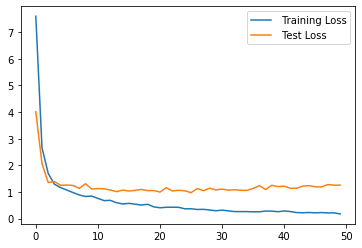

In [21]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

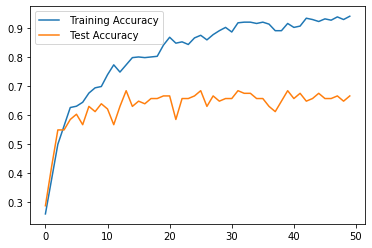

In [22]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

In [23]:
model_eval = model.evaluate(X_test,y_test, verbose=1)
model_metrics = model.metrics_names

111/111 [==============================] - 0s 45us/step


Model 2

Classifier: FNN
Features: 40 coef * 4 indicators (mean and std, delta mean delta std)
dimension 160


In [13]:
X = np.array(features_df['combined_mfccs'].tolist())
le = LabelEncoder()
y = to_categorical(le.fit_transform(features_df['class_label'].tolist()))
y = np.array(y)

In [14]:
X_train_2, X_test_2, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [15]:
ss = StandardScaler()
X_train_2 = ss.fit_transform(X_train_2)
X_test_2 = ss.transform(X_test_2)

In [16]:
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(160,)))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(5, activation='softmax'))

In [17]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [19]:
history = model2.fit(X_train_2, y_train, validation_data=(X_test_2, y_test), batch_size=32, epochs = 50, verbose=2)

Epoch 1/50
14/14 - 0s - loss: 1.4621 - accuracy: 0.3824 - val_loss: 1.1793 - val_accuracy: 0.6216
Epoch 2/50
14/14 - 0s - loss: 0.9219 - accuracy: 0.7466 - val_loss: 0.8509 - val_accuracy: 0.7748
Epoch 3/50
14/14 - 0s - loss: 0.5975 - accuracy: 0.8710 - val_loss: 0.5694 - val_accuracy: 0.8829
Epoch 4/50
14/14 - 0s - loss: 0.3767 - accuracy: 0.9321 - val_loss: 0.3938 - val_accuracy: 0.9189
Epoch 5/50
14/14 - 0s - loss: 0.2347 - accuracy: 0.9729 - val_loss: 0.2875 - val_accuracy: 0.9459
Epoch 6/50
14/14 - 0s - loss: 0.1502 - accuracy: 0.9796 - val_loss: 0.2264 - val_accuracy: 0.9550
Epoch 7/50
14/14 - 0s - loss: 0.1002 - accuracy: 0.9932 - val_loss: 0.1935 - val_accuracy: 0.9550
Epoch 8/50
14/14 - 0s - loss: 0.0708 - accuracy: 0.9977 - val_loss: 0.1674 - val_accuracy: 0.9820
Epoch 9/50
14/14 - 0s - loss: 0.0518 - accuracy: 1.0000 - val_loss: 0.1496 - val_accuracy: 0.9640
Epoch 10/50
14/14 - 0s - loss: 0.0392 - accuracy: 1.0000 - val_loss: 0.1371 - val_accuracy: 0.9640
Epoch 11/50
14/14 -

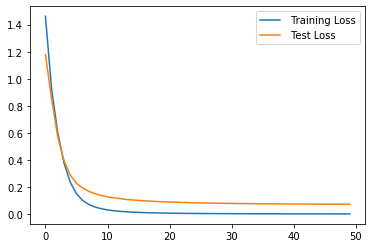

In [20]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

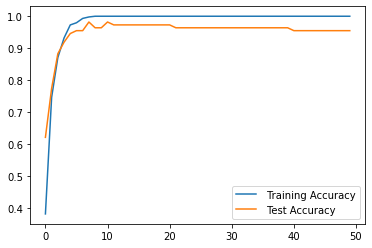

In [21]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

In [22]:
model2_eval = model2.evaluate(X_test_2,y_test, verbose=1)
model2_metrics = model2.metrics_names

4/4 [==============================] - 0s 1ms/step - loss: 0.0725 - accuracy: 0.9550


**CNN**

model 3:

classifier: CNN 2D

Features: mel spectrogram, padded until 39 sequence (128, 39)

In [34]:
X = np.array(features_df['mel'].tolist())

In [35]:
X.shape

(553, 128, 39)

In [36]:
le = LabelEncoder()
y = to_categorical(le.fit_transform(features_df['class_label'].tolist()))
y = np.array(y)

In [37]:
X.shape

(553, 128, 39)

In [38]:
X_train_3, X_test_3, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [39]:
X_train_3.shape

(442, 128, 39)

In [40]:
X_train_3 = X_train_3.reshape(X_train_3.shape[0], 128, 39, 1)
X_test_3 = X_test_3.reshape(X_test_3.shape[0], 128, 39, 1)

In [41]:
model3 = Sequential()
model3.add(Conv2D(filters = 6, kernel_size=3, activation = 'relu', input_shape = (128,39,1), padding = 'same'))
model3.add(MaxPooling2D(pool_size= (2,2), padding='same'))
model3.add(Conv2D(32, kernel_size=3, activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model3.add(Flatten())
model3.add(Dense(64, activation = 'relu'))
model3.add(Dense(32, activation = 'relu'))
model3.add(Dense(5, activation = 'softmax'))

In [42]:
model3.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [43]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 39, 6)        60        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 20, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 18, 32)        1760      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 9, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8928)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                571456    
_________________________________________________________________
dense_8 (Dense)              (None, 32)               

In [44]:
history = model3.fit(X_train_3,
                        y_train,
                        batch_size=32,
                        validation_data=(X_test_3, y_test),
                        epochs=100,
                        verbose=2)

Train on 442 samples, validate on 111 samples
Epoch 1/100
 - 1s - loss: 5.5851 - accuracy: 0.4299 - val_loss: 3.1161 - val_accuracy: 0.5405
Epoch 2/100
 - 0s - loss: 1.5102 - accuracy: 0.6652 - val_loss: 1.2317 - val_accuracy: 0.6396
Epoch 3/100
 - 0s - loss: 0.5517 - accuracy: 0.8122 - val_loss: 1.0088 - val_accuracy: 0.7387
Epoch 4/100
 - 0s - loss: 0.3037 - accuracy: 0.8914 - val_loss: 0.7912 - val_accuracy: 0.7297
Epoch 5/100
 - 0s - loss: 0.1838 - accuracy: 0.9480 - val_loss: 0.6646 - val_accuracy: 0.7297
Epoch 6/100
 - 0s - loss: 0.1313 - accuracy: 0.9615 - val_loss: 0.7039 - val_accuracy: 0.7477
Epoch 7/100
 - 0s - loss: 0.1045 - accuracy: 0.9774 - val_loss: 0.7994 - val_accuracy: 0.7297
Epoch 8/100
 - 0s - loss: 0.0753 - accuracy: 0.9932 - val_loss: 0.6703 - val_accuracy: 0.7928
Epoch 9/100
 - 0s - loss: 0.0563 - accuracy: 0.9910 - val_loss: 0.7404 - val_accuracy: 0.8018
Epoch 10/100
 - 0s - loss: 0.0407 - accuracy: 1.0000 - val_loss: 0.6855 - val_accuracy: 0.7928
Epoch 11/100


Epoch 86/100
 - 0s - loss: 4.0006e-04 - accuracy: 1.0000 - val_loss: 0.8516 - val_accuracy: 0.8198
Epoch 87/100
 - 0s - loss: 3.9264e-04 - accuracy: 1.0000 - val_loss: 0.8505 - val_accuracy: 0.8198
Epoch 88/100
 - 0s - loss: 3.8215e-04 - accuracy: 1.0000 - val_loss: 0.8558 - val_accuracy: 0.8198
Epoch 89/100
 - 0s - loss: 3.7113e-04 - accuracy: 1.0000 - val_loss: 0.8491 - val_accuracy: 0.8198
Epoch 90/100
 - 0s - loss: 3.6237e-04 - accuracy: 1.0000 - val_loss: 0.8573 - val_accuracy: 0.8198
Epoch 91/100
 - 0s - loss: 3.5372e-04 - accuracy: 1.0000 - val_loss: 0.8552 - val_accuracy: 0.8198
Epoch 92/100
 - 0s - loss: 3.4351e-04 - accuracy: 1.0000 - val_loss: 0.8597 - val_accuracy: 0.8198
Epoch 93/100
 - 0s - loss: 3.3678e-04 - accuracy: 1.0000 - val_loss: 0.8570 - val_accuracy: 0.8198
Epoch 94/100
 - 0s - loss: 3.2917e-04 - accuracy: 1.0000 - val_loss: 0.8575 - val_accuracy: 0.8198
Epoch 95/100
 - 0s - loss: 3.2014e-04 - accuracy: 1.0000 - val_loss: 0.8638 - val_accuracy: 0.8198
Epoch 96/1

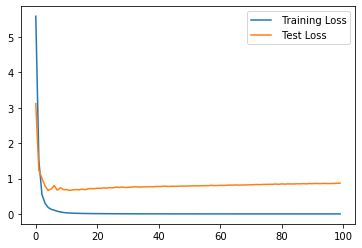

In [45]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

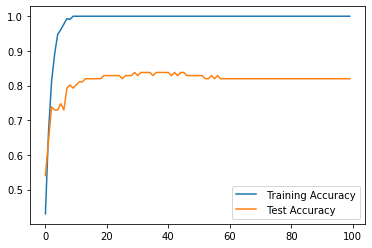

In [46]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

In [47]:
model3_eval = model3.evaluate(X_test_3,y_test, verbose=1)
model3_metrics = model3.metrics_names

111/111 [==============================] - 0s 90us/step


**CNN**

model 4:

classifier: CNN with picture WIP

In [48]:
# Not yet

**RNN**

Feeding same data as melspectrogram is possible.

In [49]:
X_train_5, X_test_5, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [50]:
model5 = Sequential()

model5.add(LSTM(64, input_shape = (128,39), return_sequences=True))
model5.add(LSTM(64, return_sequences=False ))
model5.add(Dense(64, activation = 'relu'))
model5.add(Dropout(0.3))

model5.add(Dense(5, activation = 'softmax'))

In [51]:
model5.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [52]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 64)           26624     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 325       
Total params: 64,133
Trainable params: 64,133
Non-trainable params: 0
_________________________________________________________________


In [53]:
history = model5.fit(X_train_5,
                        y_train,
                        batch_size=32,
                        validation_data=(X_test_5, y_test),
                        epochs=100,
                        verbose=2)

Train on 442 samples, validate on 111 samples
Epoch 1/100
 - 3s - loss: 1.5900 - accuracy: 0.2466 - val_loss: 1.5110 - val_accuracy: 0.2432
Epoch 2/100
 - 2s - loss: 1.4513 - accuracy: 0.3620 - val_loss: 1.3315 - val_accuracy: 0.3333
Epoch 3/100
 - 2s - loss: 1.3495 - accuracy: 0.3688 - val_loss: 1.2557 - val_accuracy: 0.3874
Epoch 4/100
 - 2s - loss: 1.2847 - accuracy: 0.4005 - val_loss: 1.2234 - val_accuracy: 0.4414
Epoch 5/100
 - 2s - loss: 1.2635 - accuracy: 0.3688 - val_loss: 1.1707 - val_accuracy: 0.4144
Epoch 6/100
 - 2s - loss: 1.1569 - accuracy: 0.4932 - val_loss: 1.1556 - val_accuracy: 0.4144
Epoch 7/100
 - 2s - loss: 1.0852 - accuracy: 0.5000 - val_loss: 0.9817 - val_accuracy: 0.5856
Epoch 8/100
 - 2s - loss: 0.9596 - accuracy: 0.6290 - val_loss: 1.0045 - val_accuracy: 0.5946
Epoch 9/100
 - 2s - loss: 1.0100 - accuracy: 0.5905 - val_loss: 0.9523 - val_accuracy: 0.5946
Epoch 10/100
 - 2s - loss: 0.8313 - accuracy: 0.6652 - val_loss: 0.9135 - val_accuracy: 0.6036
Epoch 11/100


Epoch 87/100
 - 2s - loss: 0.1904 - accuracy: 0.9344 - val_loss: 0.7107 - val_accuracy: 0.8288
Epoch 88/100
 - 2s - loss: 0.2182 - accuracy: 0.9276 - val_loss: 0.6892 - val_accuracy: 0.8468
Epoch 89/100
 - 2s - loss: 0.2595 - accuracy: 0.9299 - val_loss: 0.5939 - val_accuracy: 0.8288
Epoch 90/100
 - 2s - loss: 0.1965 - accuracy: 0.9344 - val_loss: 0.5189 - val_accuracy: 0.8739
Epoch 91/100
 - 2s - loss: 0.2188 - accuracy: 0.9321 - val_loss: 0.6823 - val_accuracy: 0.8108
Epoch 92/100
 - 2s - loss: 0.1882 - accuracy: 0.9389 - val_loss: 0.6558 - val_accuracy: 0.8108
Epoch 93/100
 - 2s - loss: 0.1604 - accuracy: 0.9525 - val_loss: 0.6853 - val_accuracy: 0.8378
Epoch 94/100
 - 2s - loss: 0.1427 - accuracy: 0.9548 - val_loss: 0.7912 - val_accuracy: 0.8018
Epoch 95/100
 - 2s - loss: 0.1381 - accuracy: 0.9570 - val_loss: 0.7744 - val_accuracy: 0.8288
Epoch 96/100
 - 2s - loss: 0.1267 - accuracy: 0.9570 - val_loss: 0.8295 - val_accuracy: 0.8108
Epoch 97/100
 - 2s - loss: 0.1225 - accuracy: 0.96

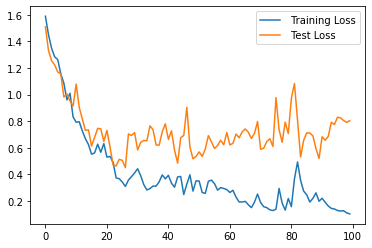

In [54]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

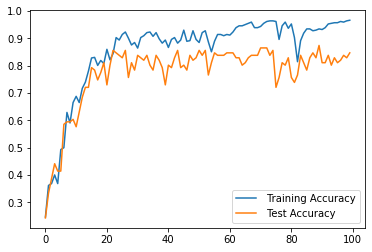

In [55]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

In [56]:
model5_eval = model5.evaluate(X_test_5,y_test, verbose=1)
model5_metrics = model5.metrics_names

111/111 [==============================] - 0s 1ms/step


**Model 6**
mfcc with padding

In [23]:
def get_mfcc(file, n_mfcc=40):
    audio, sr = librosa.load(file) 
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfccs.T

In [24]:
mfcc = features_df['filepath'].map(get_mfcc)

In [25]:
X = pad_sequences(mfcc, padding='post')

In [26]:
X.shape

(553, 39, 40)

In [61]:
X_train_6, X_test_6, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [62]:
model6 = Sequential()

model6.add(Masking(mask_value=0, input_shape=(39, 40)))
model6.add(LSTM(64, input_shape = (39,40), return_sequences=True))
model6.add(LSTM(64, return_sequences=False ))
model6.add(Dense(64, activation = 'relu'))
model6.add(Dropout(0.3))

model6.add(Dense(5, activation = 'softmax'))

In [63]:
model6.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [64]:
model6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 39, 40)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 39, 64)            26880     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 325       
Total params: 64,389
Trainable params: 64,389
Non-trainable params: 0
__________________________________________________

In [65]:
history = model6.fit(X_train_6,
                    y_train,
                    batch_size=32,
                    validation_data=(X_test_6, y_test),
                    epochs=100,
                    verbose=2)

Train on 442 samples, validate on 111 samples
Epoch 1/100
 - 2s - loss: 1.5683 - accuracy: 0.2534 - val_loss: 1.4895 - val_accuracy: 0.4955
Epoch 2/100
 - 1s - loss: 1.3896 - accuracy: 0.4615 - val_loss: 1.2068 - val_accuracy: 0.6396
Epoch 3/100
 - 1s - loss: 1.0291 - accuracy: 0.6244 - val_loss: 0.8503 - val_accuracy: 0.7027
Epoch 4/100
 - 1s - loss: 0.7518 - accuracy: 0.6810 - val_loss: 0.7017 - val_accuracy: 0.7207
Epoch 5/100
 - 1s - loss: 0.4848 - accuracy: 0.8167 - val_loss: 0.4442 - val_accuracy: 0.8108
Epoch 6/100
 - 1s - loss: 0.3150 - accuracy: 0.9072 - val_loss: 0.4069 - val_accuracy: 0.8649
Epoch 7/100
 - 1s - loss: 0.2221 - accuracy: 0.9367 - val_loss: 0.3381 - val_accuracy: 0.9009
Epoch 8/100
 - 1s - loss: 0.1386 - accuracy: 0.9570 - val_loss: 0.2847 - val_accuracy: 0.9009
Epoch 9/100
 - 1s - loss: 0.0667 - accuracy: 0.9842 - val_loss: 0.2613 - val_accuracy: 0.9189
Epoch 10/100
 - 1s - loss: 0.0393 - accuracy: 0.9932 - val_loss: 0.2542 - val_accuracy: 0.9279
Epoch 11/100


Epoch 85/100
 - 1s - loss: 4.1521e-04 - accuracy: 1.0000 - val_loss: 0.4186 - val_accuracy: 0.9099
Epoch 86/100
 - 1s - loss: 3.5306e-04 - accuracy: 1.0000 - val_loss: 0.4268 - val_accuracy: 0.9099
Epoch 87/100
 - 1s - loss: 2.8506e-04 - accuracy: 1.0000 - val_loss: 0.4309 - val_accuracy: 0.9189
Epoch 88/100
 - 1s - loss: 2.0388e-04 - accuracy: 1.0000 - val_loss: 0.4318 - val_accuracy: 0.9189
Epoch 89/100
 - 1s - loss: 3.6057e-04 - accuracy: 1.0000 - val_loss: 0.4352 - val_accuracy: 0.9189
Epoch 90/100
 - 1s - loss: 2.4761e-04 - accuracy: 1.0000 - val_loss: 0.4442 - val_accuracy: 0.9189
Epoch 91/100
 - 1s - loss: 4.0486e-04 - accuracy: 1.0000 - val_loss: 0.4510 - val_accuracy: 0.9189
Epoch 92/100
 - 1s - loss: 3.1697e-04 - accuracy: 1.0000 - val_loss: 0.4497 - val_accuracy: 0.9189
Epoch 93/100
 - 1s - loss: 2.1042e-04 - accuracy: 1.0000 - val_loss: 0.4520 - val_accuracy: 0.9189
Epoch 94/100
 - 1s - loss: 2.2384e-04 - accuracy: 1.0000 - val_loss: 0.4521 - val_accuracy: 0.9189
Epoch 95/1

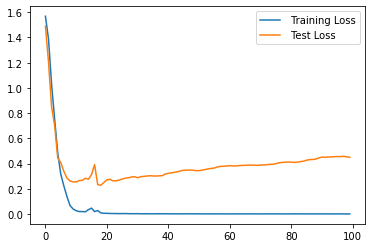

In [66]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

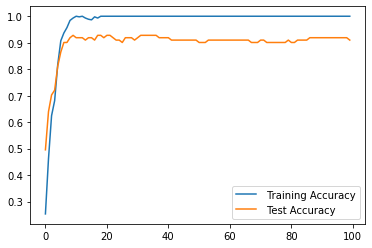

In [67]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

In [68]:
model6_eval = model6.evaluate(X_test_6,y_test, verbose=1)
model6_metrics = model6.metrics_names

111/111 [==============================] - 0s 604us/step


Model 7 
RNN with GRU

In [27]:
X_train_7, X_test_7, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [28]:
model7 = Sequential()

model7.add(Masking(mask_value=0, input_shape=(39, 40)))
model7.add(GRU(64, input_shape = (39,40), return_sequences=True))
model7.add(GRU(64, return_sequences=False ))
model7.add(Dense(64, activation = 'relu'))
model7.add(Dropout(0.3))

model7.add(Dense(5, activation = 'softmax'))

In [29]:
model7.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [30]:
model7.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 39, 40)            0         
_________________________________________________________________
gru (GRU)                    (None, 39, 64)            20352     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 49,797
Trainable params: 49,797
Non-trainable params: 0
__________________________________________________

In [31]:
history = model7.fit(X_train_7,
                    y_train,
                    batch_size=32,
                    validation_data=(X_test_7, y_test),
                    epochs=100,
                    verbose=2)

Epoch 1/100
14/14 - 5s - loss: 1.5476 - accuracy: 0.3235 - val_loss: 1.4030 - val_accuracy: 0.5135
Epoch 2/100
14/14 - 1s - loss: 1.2878 - accuracy: 0.5588 - val_loss: 1.1716 - val_accuracy: 0.5856
Epoch 3/100
14/14 - 1s - loss: 1.0631 - accuracy: 0.5701 - val_loss: 0.9537 - val_accuracy: 0.7027
Epoch 4/100
14/14 - 1s - loss: 0.8373 - accuracy: 0.7217 - val_loss: 0.7797 - val_accuracy: 0.7207
Epoch 5/100
14/14 - 1s - loss: 0.6398 - accuracy: 0.7919 - val_loss: 0.6271 - val_accuracy: 0.8018
Epoch 6/100
14/14 - 1s - loss: 0.4691 - accuracy: 0.8801 - val_loss: 0.5364 - val_accuracy: 0.7568
Epoch 7/100
14/14 - 1s - loss: 0.3304 - accuracy: 0.9140 - val_loss: 0.3807 - val_accuracy: 0.8468
Epoch 8/100
14/14 - 1s - loss: 0.1931 - accuracy: 0.9615 - val_loss: 0.3047 - val_accuracy: 0.8829
Epoch 9/100
14/14 - 1s - loss: 0.1329 - accuracy: 0.9638 - val_loss: 0.3371 - val_accuracy: 0.8739
Epoch 10/100
14/14 - 1s - loss: 0.0904 - accuracy: 0.9796 - val_loss: 0.2666 - val_accuracy: 0.9279
Epoch 11/

Epoch 82/100
14/14 - 1s - loss: 2.2017e-04 - accuracy: 1.0000 - val_loss: 0.7268 - val_accuracy: 0.9009
Epoch 83/100
14/14 - 1s - loss: 2.2714e-04 - accuracy: 1.0000 - val_loss: 0.7314 - val_accuracy: 0.9009
Epoch 84/100
14/14 - 1s - loss: 2.7704e-04 - accuracy: 1.0000 - val_loss: 0.7328 - val_accuracy: 0.9009
Epoch 85/100
14/14 - 1s - loss: 7.1736e-04 - accuracy: 1.0000 - val_loss: 0.7479 - val_accuracy: 0.8919
Epoch 86/100
14/14 - 1s - loss: 2.1088e-04 - accuracy: 1.0000 - val_loss: 0.7832 - val_accuracy: 0.9009
Epoch 87/100
14/14 - 1s - loss: 3.9535e-04 - accuracy: 1.0000 - val_loss: 0.7266 - val_accuracy: 0.8919
Epoch 88/100
14/14 - 1s - loss: 2.9169e-04 - accuracy: 1.0000 - val_loss: 0.7181 - val_accuracy: 0.9009
Epoch 89/100
14/14 - 1s - loss: 3.6301e-04 - accuracy: 1.0000 - val_loss: 0.7303 - val_accuracy: 0.9009
Epoch 90/100
14/14 - 1s - loss: 3.9659e-04 - accuracy: 1.0000 - val_loss: 0.7547 - val_accuracy: 0.9009
Epoch 91/100
14/14 - 1s - loss: 2.7298e-04 - accuracy: 1.0000 - 

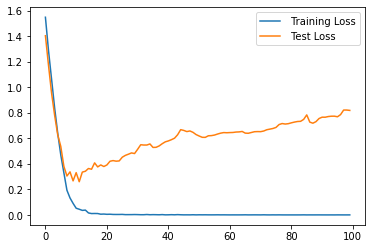

In [32]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

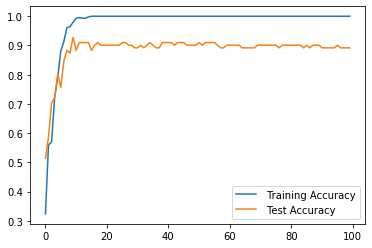

In [33]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

In [34]:
model7_eval = model7.evaluate(X_test_7, y_test, verbose=1)
model7_metrics = model7.metrics_names

4/4 [==============================] - 0s 10ms/step - loss: 0.8182 - accuracy: 0.8919


## Evaluation


In [56]:
from sklearn.metrics import classification_report, confusion_matrix

In [78]:
print(f"Model 1 {model_metrics[0]}: {model_eval[0]}")
print(f"Model 1 {model_metrics[1]}: {model_eval[1]}\n")

print(f"Model 2 {model2_metrics[0]}: {model2_eval[0]}")
print(f"Model 2 {model2_metrics[1]}: {model2_eval[1]}\n")

print(f"Model 3 {model3_metrics[0]}: {model3_eval[0]}")
print(f"Model 3 {model3_metrics[1]}: {model3_eval[1]}\n")

print(f"Model 5 {model5_metrics[0]}: {model5_eval[0]}")
print(f"Model 5 {model5_metrics[1]}: {model5_eval[1]}\n")

print(f"Model 6 {model6_metrics[0]}: {model6_eval[0]}")
print(f"Model 6 {model6_metrics[1]}: {model6_eval[1]}\n")

print(f"Model 7 {model7_metrics[0]}: {model7_eval[0]}")
print(f"Model 7 {model7_metrics[1]}: {model7_eval[1]}\n")


Model 1 loss: 1.2562414482907132
Model 1 accuracy: 0.6666666865348816

Model 2 loss: 0.11317312287854718
Model 2 accuracy: 0.9729729890823364

Model 3 loss: 0.8697421808500547
Model 3 accuracy: 0.8198198080062866

Model 5 loss: 0.803975443582277
Model 5 accuracy: 0.8468468189239502

Model 6 loss: 0.4491835198960863
Model 6 accuracy: 0.9099099040031433

Model 7 loss: 0.5485324527321568
Model 7 accuracy: 0.9099099040031433



Get Predictions for Each Model

In [81]:
labels = list(le.classes_)

y_test_labels = []
for pred in y_test:
    for n, i in enumerate(pred):
        if i == 1:
            y_test_labels.append(labels[n])
            
y_test_labels

['apples',
 'father',
 'flowers',
 'father',
 'flowers',
 'flowers',
 'water',
 'worker',
 'apples',
 'worker',
 'flowers',
 'water',
 'water',
 'flowers',
 'father',
 'apples',
 'father',
 'apples',
 'father',
 'flowers',
 'flowers',
 'water',
 'water',
 'apples',
 'flowers',
 'water',
 'worker',
 'apples',
 'father',
 'flowers',
 'worker',
 'apples',
 'apples',
 'apples',
 'flowers',
 'apples',
 'flowers',
 'apples',
 'flowers',
 'water',
 'father',
 'apples',
 'apples',
 'father',
 'water',
 'flowers',
 'father',
 'water',
 'worker',
 'father',
 'worker',
 'flowers',
 'water',
 'water',
 'water',
 'worker',
 'water',
 'flowers',
 'worker',
 'apples',
 'water',
 'worker',
 'father',
 'water',
 'father',
 'worker',
 'apples',
 'father',
 'father',
 'worker',
 'flowers',
 'apples',
 'worker',
 'apples',
 'water',
 'father',
 'father',
 'father',
 'apples',
 'flowers',
 'flowers',
 'father',
 'flowers',
 'water',
 'water',
 'water',
 'worker',
 'father',
 'worker',
 'worker',
 'father',

In [82]:
y_pred = model.predict_classes(X_test)
y_pred = list(le.inverse_transform(y_pred))

print(classification_report(y_test_labels, y_pred))

              precision    recall  f1-score   support

      apples       0.65      0.68      0.67        22
      father       0.78      0.64      0.70        22
     flowers       0.46      0.59      0.52        22
       water       0.70      0.73      0.71        22
      worker       0.84      0.70      0.76        23

    accuracy                           0.67       111
   macro avg       0.69      0.67      0.67       111
weighted avg       0.69      0.67      0.67       111



In [83]:
y_pred2 = model2.predict_classes(X_test_2)
y_pred2 = list(le.inverse_transform(y_pred2))

print(classification_report(y_test_labels, y_pred2))

              precision    recall  f1-score   support

      apples       0.96      1.00      0.98        22
      father       0.96      1.00      0.98        22
     flowers       1.00      0.95      0.98        22
       water       1.00      0.91      0.95        22
      worker       0.96      1.00      0.98        23

    accuracy                           0.97       111
   macro avg       0.97      0.97      0.97       111
weighted avg       0.97      0.97      0.97       111



In [84]:
y_pred3 = model3.predict_classes(X_test_3)
y_pred3 = list(le.inverse_transform(y_pred3))

print(classification_report(y_test_labels, y_pred3))

              precision    recall  f1-score   support

      apples       0.79      0.86      0.83        22
      father       0.75      0.82      0.78        22
     flowers       0.85      0.77      0.81        22
       water       0.93      0.64      0.76        22
      worker       0.82      1.00      0.90        23

    accuracy                           0.82       111
   macro avg       0.83      0.82      0.82       111
weighted avg       0.83      0.82      0.82       111



In [85]:
y_pred5 = model5.predict_classes(X_test_5)
y_pred5 = list(le.inverse_transform(y_pred5))

print(classification_report(y_test_labels, y_pred5))

              precision    recall  f1-score   support

      apples       0.95      0.82      0.88        22
      father       0.80      0.73      0.76        22
     flowers       0.78      0.82      0.80        22
       water       0.80      0.91      0.85        22
      worker       0.92      0.96      0.94        23

    accuracy                           0.85       111
   macro avg       0.85      0.85      0.85       111
weighted avg       0.85      0.85      0.85       111



In [86]:
y_pred6 = model6.predict_classes(X_test_6)
y_pred6 = list(le.inverse_transform(y_pred6))

print(classification_report(y_test_labels, y_pred6))

              precision    recall  f1-score   support

      apples       0.95      0.91      0.93        22
      father       0.91      0.91      0.91        22
     flowers       0.90      0.82      0.86        22
       water       0.84      0.95      0.89        22
      worker       0.96      0.96      0.96        23

    accuracy                           0.91       111
   macro avg       0.91      0.91      0.91       111
weighted avg       0.91      0.91      0.91       111



In [87]:
y_pred7 = model7.predict_classes(X_test_7)
y_pred7 = list(le.inverse_transform(y_pred7))

print(classification_report(y_test_labels, y_pred7))

              precision    recall  f1-score   support

      apples       0.88      0.95      0.91        22
      father       0.88      0.95      0.91        22
     flowers       0.90      0.86      0.88        22
       water       0.95      0.91      0.93        22
      worker       0.95      0.87      0.91        23

    accuracy                           0.91       111
   macro avg       0.91      0.91      0.91       111
weighted avg       0.91      0.91      0.91       111



The top 2 performing models are Model 2 and Model 7, based on the accuracy and the f1 score.

**Unseen Data**

In [35]:
# import test data
test_df = pd.read_csv("./datasets/testdf.csv")
test_df.head()

,id,filepath,duration,class_label
0,30034,./assets/audio_test/30034_apples.wav,0.416780,apples
1,30008,./assets/audio_test/30008_flowers.wav,0.530839,flowers
2,30009,./assets/audio_test/30009_worker.wav,0.496417,worker
3,30095,./assets/audio_test/30095_water.wav,0.250340,water
4,30009,./assets/audio_test/30009_father.wav,0.369569,father


In [60]:
# preprocess the same as previously
test_mfccs_features = get_mfccs_features(test_df['filepath'])


In [61]:
# add them into the dataframe

for k, v in test_mfccs_features.items():
    test_df[k] = v

In [62]:
# create a new feature with a dimension of 160, stacking the mean and standard deviation of 
# the mfcc and its delta.

combined_features = []
for n in range(0,len(test_df)):
    combined_features.append(np.concatenate((test_df['mfccs_mean'][n],
                                             test_df['mfccs_std'][n], 
                                             test_df['mfccs_delta_mean'][n],
                                             test_df['mfccs_delta_std'][n])))
    
test_df['combined_mfccs'] = combined_features
# this will give us an array of (160, 1)

In [63]:
test_df

,id,filepath,duration,class_label,mfccs_mean,mfccs_std,mfccs_delta_mean,mfccs_delta_std,combined_mfccs
0,30034,./assets/audio_test/30034_apples.wav,0.416780,apples,"[-198.50255, 131.26993, -25.532259, 52.081627,...","[80.31956, 54.221424, 18.007969, 16.541662, 22...","[-10.8114605, -10.25785, 1.6027119, -0.9453479...","[16.318327, 9.497107, 3.1491222, 5.0818477, 3....","[-198.50255, 131.26993, -25.532259, 52.081627,..."
1,30008,./assets/audio_test/30008_flowers.wav,0.530839,flowers,"[-236.50839, 126.737175, -31.233444, 43.39643,...","[45.6092, 68.03514, 17.97645, 23.997889, 15.24...","[2.9926207, -3.0669036, -0.34088498, 0.8820659...","[12.488578, 17.499315, 2.8168445, 6.1881804, 3...","[-236.50839, 126.737175, -31.233444, 43.39643,..."
2,30009,./assets/audio_test/30009_worker.wav,0.496417,worker,"[-232.32349, 164.00572, -5.2090764, 20.472998,...","[84.08268, 31.5341, 26.128588, 17.994024, 19.4...","[-7.6272078, -5.043338, -1.5057583, -2.495122,...","[19.266191, 7.8296046, 5.9707665, 4.55391, 2.3...","[-232.32349, 164.00572, -5.2090764, 20.472998,..."
3,30095,./assets/audio_test/30095_water.wav,0.250340,water,"[-226.49066, 164.1956, -2.9555368, 37.79291, -...","[91.47749, 32.853287, 32.325573, 17.542824, 17...","[15.646426, -7.8981886, -6.892499, 5.9317565, ...","[0.71244466, 2.5768838, 1.6155096, 0.36419478,...","[-226.49066, 164.1956, -2.9555368, 37.79291, -..."
4,30009,./assets/audio_test/30009_father.wav,0.369569,father,"[-202.17143, 156.89734, -48.638046, 33.756462,...","[54.025196, 44.427963, 17.945734, 12.036269, 1...","[4.1709566, 7.26626, -0.1926024, -0.7872772, 2...","[16.879608, 8.494881, 5.466756, 2.7808282, 3.6...","[-202.17143, 156.89734, -48.638046, 33.756462,..."
5,60066,./assets/audio_test/60066_apples.wav,2.881043,apples,"[-373.69272, 113.312355, -34.333557, 29.849167...","[144.46051, 53.9207, 42.039967, 26.369184, 26....","[0.7257655, 0.31434554, -0.025032733, 0.075665...","[20.325785, 6.5486608, 7.388167, 5.365542, 5.4...","[-373.69272, 113.312355, -34.333557, 29.849167..."
6,60062,./assets/audio_test/60062_flowers.wav,0.477778,flowers,"[-211.78532, 128.9489, -52.388325, 37.95728, -...","[53.18248, 53.56442, 22.164488, 25.994394, 14....","[-0.16116378, -3.61797, -0.29590768, 2.3910146...","[13.673466, 12.8961735, 5.3578243, 5.623616, 3...","[-211.78532, 128.9489, -52.388325, 37.95728, -..."
7,60049,./assets/audio_test/60049_worker.wav,0.346576,worker,"[-214.61972, 170.96431, -14.436518, 33.140736,...","[75.06599, 24.77091, 40.655807, 20.495346, 18....","[4.132118, 0.78200185, -2.1928177, -1.1271892,...","[14.484798, 4.139307, 11.658692, 2.8645506, 2....","[-214.61972, 170.96431, -14.436518, 33.140736,..."
8,60051,./assets/audio_test/60051_water.wav,0.500136,water,"[-234.83765, 145.21213, -16.12923, 32.834755, ...","[105.41433, 27.252125, 43.530193, 16.71434, 25...","[3.343184, -0.9838396, -2.5826368, -0.6370913,...","[18.136984, 4.3474774, 7.250479, 4.3870416, 5....","[-234.83765, 145.21213, -16.12923, 32.834755, ..."
9,60049,./assets/audio_test/60049_father.wav,0.371837,father,"[-170.79102, 151.00348, -71.76117, 21.137316, ...","[42.694633, 47.012444, 33.231354, 26.419619, 1...","[5.2645693, 2.6756222, -0.88654345, -0.8679753...","[9.66988, 12.436902, 8.395563, 7.730953, 1.315...","[-170.79102, 151.00348, -71.76117, 21.137316, ..."


In [64]:
X = np.array(test_df['combined_mfccs'].tolist())

In [65]:
model2.predict_classes(X)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3], dtype=int64)

In [49]:
def get_mfcc(file, n_mfcc=40):
    audio, sr = librosa.load(file) 
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfccs.T

In [100]:
mfcc_test = test_df['filepath'].map(get_mfcc)

In [101]:
X = pad_sequences(mfcc_test, padding='post')

In [102]:
X.shape

(45, 125, 40)

In [53]:
y_test_pred = model7.predict_classes(X)

In [54]:
y_test_pred = list(le.inverse_transform(y_test_pred))

In [58]:
print(classification_report(test_df['class_label'], y_test_pred))

              precision    recall  f1-score   support

      apples       1.00      0.78      0.88         9
      father       0.90      1.00      0.95         9
     flowers       0.80      0.89      0.84         9
       water       0.82      1.00      0.90         9
      worker       1.00      0.78      0.88         9

    accuracy                           0.89        45
   macro avg       0.90      0.89      0.89        45
weighted avg       0.90      0.89      0.89        45

